# NYC Subway Ridership - P2
## Karthik Rajasethupathy
### karbar09@gmail.com

In [1]:
%pylab inline
import pandas
import numpy
import pandasql
from ggplot import *
np.random.seed(10)
df = pandas.read_csv('improved-dataset/turnstile_weather_v2.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Preprocessing:

#1 Split data set on rain vs. not rain, and extract the column of interest ENTRIESn_hourly
rain = df[df.rain == 1]['ENTRIESn_hourly']
not_rain = df[df.rain == 0]['ENTRIESn_hourly']
#2 Descriptive Statistics
print "Rain: ",round(np.mean(rain),2), np.median(rain), len(rain)
print "Not Rain: ",round(np.mean(not_rain),2),np.median(not_rain), len(not_rain)
print 
print rain.describe() > not_rain.describe()

#The mean entries during rain are quite a bit higher, but the standard deviation is higher as well. 
#At each quartile (25/50-median/75), ENTRIESn_hourly are higher in the the rain versus no rain. The effect of outliers
#influences the mean/std, but has less influence over quartiles (including the median). So, we see that the median 
#ENTRIESn_hourly is higher during rain.


Rain:  2028.2 939.0 9585
Not Rain:  1845.54 893.0 33064

count    False
mean      True
std       True
min      False
25%       True
50%       True
75%       True
max      False
Name: ENTRIESn_hourly, dtype: bool


In [84]:
#Section 1. Statistical Test Code

from scipy.stats import ttest_ind,shapiro,mannwhitneyu

#Shapiro test for normality - Neither sample is normal
#H0 - samples are normal
#HA - samples are not normal
#In both cases, reject null hypothesis: both p-values <.001
s1,s_p1 = shapiro(rain)
s2,s_p2 = shapiro(not_rain)

#Two-Tailed Mann Whitney U test to see whether the samples come from the same distribution
#Suppose r, nr are randomly drawn from the Rain, Not Rain populations respectively, then:
#H0: P(r>nr)=0.5
#HA: P(r>nr)!=0.5
#Reject null hypothesis: p-value <.05
U,u_p = mannwhitneyu(rain,not_rain)
#IMPORTANT the p value is doubled from the MWU test, as the scipy documentation states 
#that this function returns a 1 sided p-value
u_p_doubled = u_p *2 


print "Shapiro Wilks: Rain", s1,s_p1
print "Shapiro Wilks: Rain", s2,s_p2
print "Mann Whitney U (Two Tailed): Rain, Not Rain", U, u_p_doubled #


Shapiro Wilks: Rain 0.593882083893 0.0
Shapiro Wilks: Rain 0.595618069172 0.0
Mann Whitney U (Two Tailed): Rain, Not Rain 153635120.5 5.48213914249e-06


###Section 1. Statistical Test Responses

**Which statistical test did you use to analyze the NYC subway data? Did you use a one-tail or a two-tail P value? What is the null hypothesis? What is your p-critical value?**

I used two-tailed Mann Whitney U Test to analyze the NYC subway data. Given random draws r,nr from populations Rain, Not Rain respectively, the Null Hypothesis states:

- HO: P(r>nr)=0.5 - This is a test of whether or not one distribution is likely to generate a higher value than the other (From the Udacity Mann Whitney U docs. See **References section** for link)

Therefore, the two sided alternative hypothesis is:

- HA: P(r>nr)!= 0.5

I set p-critical value of alpha = .05 for this test.

**Why is this statistical test applicable to the dataset? In particular, consider the assumptions that the test is making about the distribution of ridership in the two samples.**

- The Mann Whitney U test is a non-parametric test that is applicable to the dataset because the distributions of ridership under the rain/no-rain conditions follow a non-normal distribution.
- To statistically validate the conclusion above, i ran a shapiro wilks test on each of the two conditions: rain/not-rain, and received p-values < .001 for both data sets, thereby rejecting the null hyothesis that each sample is drawn from a normal distribution
- Therefore, the Mann Whitney U test is applicable to our dataset because it does not assume that our data is drawn from any particular underlying distribution.

**What results did you get from this statistical test? These should include the following numerical values: p-values, as well as the means for each of the two samples under test.**

Results from this test: 

- U statistic  = 153635120.5, two tailed p value (the p value returned by the mwu test in scipy is 1 tailed) = 5.48213914249e-06
- rain_mean ~= 2028, not_rain_mean ~= 1845
- rain_median ~= 939, not_rain_median ~= 893

**What is the significance and interpretation of these results?**

- The descriptive statistics (mean, median) supplement our underlying belief that ridership is higher during rain, but, the Mann-Whitney U test doesnt make a statement about this. However, given the p-value <.0001, it says that probability that the two samples are the same given this data is very very low. So, we can reject this null hypothesis at the alpha = .05 level. These samples are not the same, and combined with our descriptive statistics, we know that the mean/median for the rain data are higher than that of the not_rain data.

In [35]:
#2: Prediction - OLS
import numpy as np
import pandas
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import r2_score
from sklearn import covariance
from statsmodels.stats.outliers_influence import *
import statsmodels.api as sm
linalg = np.linalg


def normalize_features(features):
    ''' 
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    ''' 
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features

def recover_params(means, std_devs, norm_intercept, norm_params):
    ''' 
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    ''' 
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params

def linear_regression_ols(features, values):
    """
    OLS
    """
    features = sm.add_constant(features)
    #Deals with multi-colinearity
    features = independent_columns(features)
    model = sm.OLS(values, features)
    results = model.fit()
    intercept = results.params[0]
    params = results.params[1:]
    print results.summary()
    return model,results,intercept, params

def linear_regression_sgd(features, values):
    """
    SGD
    """
    
    clf = SGDRegressor(n_iter = 200)
    clf.fit(features, values)
    intercept = clf.intercept_
    params = clf.coef_
    return intercept, params


#http://stackoverflow.com/q/13312498/190597
def independent_columns(A, tol = 1e-05):
    """
    To avoid remove columns causing multicollinearity warnings in OLS
    Return an array composed of independent columns of A.
    """
    Q, R = linalg.qr(A)
    independent = np.where(np.abs(R.diagonal()) > tol)[0]
    return A[:, independent]

def predictions(dataframe):
    dataframe['hour'] = dataframe['hour'].astype(str)
    dataframe['weekday'] = dataframe['weekday'].astype(str)
    features = dataframe[['rain']]#, 'precipi', 'fog','pressurei','tempi','wspdi'
    dummy_units = pandas.get_dummies(dataframe[['UNIT','hour','weekday']], prefix='unit')#,'weekday','hour'
    features = features.join(dummy_units)
    # Values
    values = dataframe['ENTRIESn_hourly']
    
    # Get numpy arrays
    features_array = features.values
    values_array = values.values
    
    means, std_devs, normalized_features_array = normalize_features(features_array)

    # Perform gradient descent or ols
    model,results,norm_intercept, norm_params = linear_regression_ols(normalized_features_array, values_array)
    return model,results

model,res = predictions(df)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.538
Method:                 Least Squares   F-statistic:                     202.9
Date:                Sat, 08 Aug 2015   Prob (F-statistic):               0.00
Time:                        15:39:07   Log-Likelihood:            -3.8470e+05
No. Observations:               42649   AIC:                         7.699e+05
Df Residuals:                   42402   BIC:                         7.720e+05
Df Model:                         246                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const       1886.5900      9.717    194.163      0.0

###Section 2. Linear Regression

**What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model**:

I tried both Gradient descent using Scikit Learn and OLS were tried. Because the OLS returns a thorough summary, including std err's for the intercept, t values, confidence intervals, and warnings with regards to multicolinearity, I will report the results below based on the OLS runs. 

*Note*: To deal with multicolinearity in the OLS model, I first normalized the features, and then selected columns who's eigenvalues were greater than some small epsilon (in other words, i selected the linearly independent columns of the feature matrix).


**What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?**

I did use some dummy variables in my model. Here are all the selected features
- rain (treated as numeric), UNIT (dummy), hour (dummy), weekday (dummy) 
Additionally, I added an intercept term in the OLS. 
    

**Why did you select these features in your model? [Provide intuition or evidence]**

*Rain*: I selected rain based on the descriptive statistics in problem 1. Although it's impact in the overall model has been minimal as far as influencing the R2, the intuition that ridership will increase during rain seems to be strong. Additionally, the descriptive statistics in question 1, combined with the Mann-Whitney U test that indicates the distributions of ridership under different rain conditions seemed to indicate some importance for this attribute.

*UNIT*: I selected *UNIT* and built a model based on this feature alone, and obtained an R2 value of ~.40. Whenever *UNIT* was removed, the R2 fell quite low. So, it seems that much of the variance in ENTRIESn_hourly is explained by this attribute. This makes sense because UNIT is at some level, representative of the station. 

*hour*: Once again, from both an intuitive perspective and based on the impact of this feature on the R2 value, including *hour* made sense. Ridership would be much higher during rush hour, or commute times in general. Hence, including this attribute would help explain changes in ridership across different times of the day.

*weekday*: Similar to my logic for *hour*, i added weekday because I think ridership is quite different on weekdays versus weekends. I believe both *hour* and *weekday* would explain some of the variation in ridership that is due to work/leisure habits (commutes, etc).

**What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?**

The weight of the OLS models' *intercept* is 1886.59, and the weight of the *rain* feature is 16.95.

**What is your model’s R2 (coefficients of determination) value?

The model's R2 is .54.

**What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?**

54% of the variation in the dependent variable ENTRIESn_hourly is explained by the independent variables (predictors). Based on some of the discussions in the Udacity boards (such as this one: https://discussions.udacity.com/t/project-1-linear-regression/23870/2), it seems that an R2>.4 is not bad. I think this linear model is alright, *given this dataset*.  However, there are definitely latent variables that not included in this regression. I did a residual analysis that demonstrates this: I plotted a histogram of the residuals (Shown 1 cell below), the differences between my actual value and the predicated value, and see that although the distribution of the residuals might seem normal at first glance, a closer look indicates that there are some rather long tails: large residuals. So, the residuals may not be normally distributed. I could've taken this a step further and performed a Shapiro-Wilks test on the residuals to solidfy this point. I did not do this, but I got a great recommendation to do a probability plot of the residuals (Shown 2 cells below) using scipy probplot (See **References** for link). The figure shows a plot of the residuals against the quantiles of a theorectical normal distribution. If the residuals followed normal distrbution, we would see the points fall closely to the line. However, it is clear that the existence of large residuals skews the points upward, and away from the line. In conclusion, although the R2 value is satisfactory, it does not tell the whole story. The analysis of the residuals indicates possibly a consistent source of bias in the errors, and perhaps the ommission of one or more important variables. 

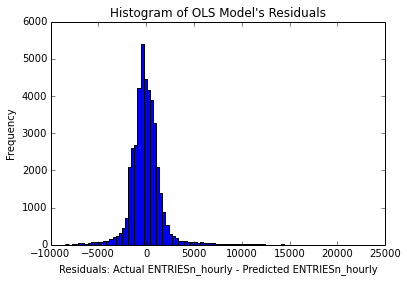

In [97]:
#To help answer question 2.5 above
from scipy.stats import probplot
import matplotlib.pyplot as plt 
#Distribution of Residuals
out = plt.hist(res.resid,bins=100)
plt.xlabel("Residuals: Actual ENTRIESn_hourly - Predicted ENTRIESn_hourly")
plt.ylabel("Frequency")
plt.title("Histogram of OLS Model's Residuals")

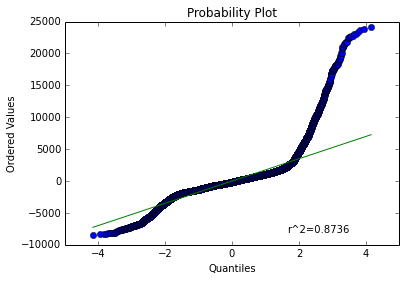

In [98]:
#To help answer question 2.5 above
#Probplot of Residuals: http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
probplot(res.resid,plot= plt)
plt.show()

###Section 3. Visualization

Please include two visualizations that show the relationships between two or more variables in the NYC subway data.
Remember to add appropriate titles and axes labels to your plots. Also, please add a short description below each figure commenting on the key insights depicted in the figure.

3.1 One visualization should contain two histograms: one of  ENTRIESn_hourly for rainy days and one of ENTRIESn_hourly for non-rainy days.
You can combine the two histograms in a single plot or you can use two separate plots.
If you decide to use to two separate plots for the two histograms, please ensure that the x-axis limits for both of the plots are identical. It is much easier to compare the two in that case.
For the histograms, you should have intervals representing the volume of ridership (value of ENTRIESn_hourly) on the x-axis and the frequency of occurrence on the y-axis. For example, each interval (along the x-axis), the height of the bar for this interval will represent the number of records (rows in our data) that have ENTRIESn_hourly that falls in this interval.
Remember to increase the number of bins in the histogram (by having larger number of bars). The default bin width is not sufficient to capture the variability in the two samples.

3.2 One visualization can be more freeform. You should feel free to implement something that we discussed in class (e.g., scatter plots, line plots) or attempt to implement something more advanced if you'd like. Some suggestions are:
Ridership by time-of-day
Ridership by day-of-week

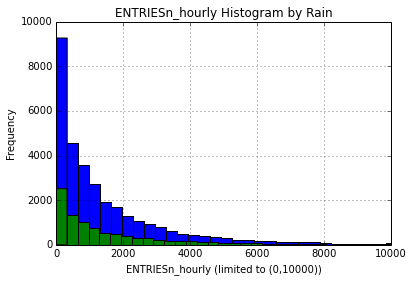

In [99]:
#3.1
#Would've done this in ggplot. 
#But there is an issue with the latest version of pandas and ggplot: https://github.com/yhat/ggplot/issues/417
import matplotlib.pyplot as plt 
bins = 100
plt.figure()
df[df.rain==0]['ENTRIESn_hourly'].hist(bins=bins) # No Rain => Blue
df[df.rain==1]['ENTRIESn_hourly'].hist(bins=bins) # Rain => Green
plt.xlim((0,10000))
plt.xlabel("ENTRIESn_hourly (limited to (0,10000))")
plt.ylabel("Frequency")
plt.title("ENTRIESn_hourly Histogram by Rain")
plt.show()

###3.1 Description:

In the figure above, two histograms are shown regarding ridership when there's no rain (Blue), and where there is rain (Green). A max limit is set on the X-axis to 10000 (ENTRIESn_hourly < 10000) because both frequencies continue trending downward. There is no discernable increase in frequency as ridership increases. Both of these distributions are heavily right skewed, and look exponential.

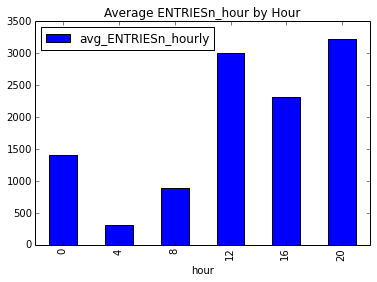

In [100]:
#3.2
sql = """
select
    hour,
    avg(ENTRIESn_hourly) as avg_ENTRIESn_hourly
from
    df
group by
    hour
"""
sub = pandasql.sqldf(sql,locals())
sub['hour'] = sub['hour'].astype(int)
sub = sub.sort('hour',ascending=True)
sub.plot(kind='bar',x='hour',y='avg_ENTRIESn_hourly',title='Average ENTRIESn_hour by Hour')
#df.groupby('hour')

###3.2 Description:
In the figure above, we see a bar chart of the average ridership by the *hour* column. We see a local maximum at Midnight (0), followed by a global minimum in ridership at 4am, and two peaks around noon and 8pm (assuming datetimes are in Eastern Time - not specified in the turnstile schema pdf).

###Section 4. Conclusion

**From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining? What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.**

Given the analyses, I think that more people ride the NYC subway when it is raining. The descriptive stats indicate higher mean and median ridership during days that had rain. Additionally, the Mann Whitney U test tells us that the distributions of ridership on rain/not rain days are different. Therefore, based on the statistical analysis, the means are different with statistical significance and more people ride the NYC subway when it is raining.

From the linear regression, we observe that the coefficient for the *rain* attribute in the OLS regression is 16.95. This indicates, that, all things equal, a 1 unit increase in *rain* (of course, this is a binary attribute, so what i mean by 1 unit increase is simply the different between rain = 0, and rain = 1) leads to a 16.95 increase in Ridership. So, there's a positive relationship between rain and ridership. When's its raining, there are more riders!





###Section 5. Reflection

**Please discuss potential shortcomings of the methods of your analysis, including: Dataset, Analysis, such as the linear regression model or statistical test. Do you have any other insight about the dataset that you would like to share with us?**

I could've used feature selection techniques such as SelectKBest to do more robust selection. Addtionally, the dataset only contains information about May 2011. It's possible that it simply rained more in this month. I would be curious to see if inclement weather of any kind leads to variation in ridership -- therefore, i would like to see more samples from different times of the year. Additionally, there was more than I could've done in terms of checking data quality/availability, and removing the top/bottom 1% of ridership days to see how impactful this would be on the mean. This makese sense to to do since the distributions are so exponential (although, the median was examined). As far as the linear regression model, I think that researching multicolinearity and looking into techniques to removed features that were linearly dependent upon other features was a good and useful exercise. However, i didn't identify exactly which features were removed (~3 columns were removed, i believe they are all dummy variables). An interesting technique I learned during this project is the Variance Inflation Factor (VIF- https://en.wikipedia.org/wiki/Variance_inflation_factor) which is a measure of the severity of the collinearity in a predictor by measuring how much of the predictor's regression coefficient's variance is amplified by the presence of collinear predictors. 

An insight about the technique, is that linear regression may not be a suitable model for this. My last grader gave me a really great visualization of a cyclic, non-linear pattern in the residuals that a linear model, even with the best features, may not be able to caputure (Please see figure in cell below). I would be curious to see what are some feasible approaches to non-linear regression. For example, would models like CART which use the non-linear classification capabilities of decicision trees with numerical prediction from regression be able to handle this problem?

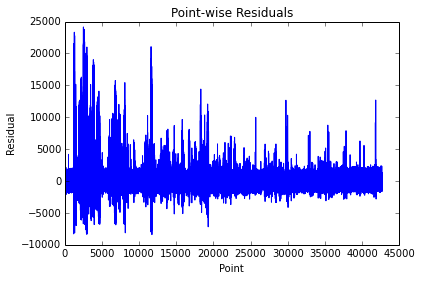

In [101]:
import matplotlib.pyplot as plt
plt.plot(df['ENTRIESn_hourly'].values - res.predict())
plt.xlabel("Point")
plt.ylabel("Residual")
plt.title("Point-wise Residuals")
plt.show()

###References:

- Udacity Mann Whitney U test - https://storage.googleapis.com/supplemental_media/udacityu/4332539257/MannWhitneyUTest.pdf?GoogleAccessId=1069728276824-fdhtlb98k1m9qrmdgj4jgc7gjp2l1lsm@developer.gserviceaccount.com&Expires=1439017584&Signature=PEKwNCPwFcpQG5YB%2BMXRPedACpMeaguJ1CQN7UxVCE9SQQhPygZX1AjCqmJrx4nry2NC0Ki9jWvcWv4Bdg9btaV1nW6S9u3%2B881ZZgQEghyr1QduNGfLfAvlv9qYgsKYkS1SlJEgvgjdlSjuw/bCI64FAftGCuo1QXxs1r9y2mU%3D
- Scipy prob plot - http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html
- Code to remove multicolinearity - http://stackoverflow.com/q/13312498/190597
- Base code for normalizations, linear regression ols, and prediction - Udacity Intro to Data Science
- Plotting Residuals: http://www.itl.nist.gov/div898/handbook/pri/section2/pri24.htm
- Evaluating R2: https://discussions.udacity.com/t/project-1-linear-regression/23870/2
- Variance Inflation Factor: https://en.wikipedia.org/wiki/Variance_inflation_factor